# GNN 기반 영화 추천 시스템
# V9A: Temperature & Negative Ratio Tuning
# Step 1 실험 - sharper, more aggressive

In [1]:
# !pip install -q torch_geometric

In [2]:
import os
import pickle
import random
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import degree

from tqdm.notebook import tqdm

# 시각화 설정
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("=" * 60)
print("환경 설정")
print("=" * 60)
print(f"PyTorch 버전: {torch.__version__}")
print(f"CUDA 사용 가능: {torch.cuda.is_available()}")
print(f"MPS 사용 가능: {torch.backends.mps.is_available()}")
print("=" * 60)

환경 설정
PyTorch 버전: 2.9.0
CUDA 사용 가능: False
MPS 사용 가능: True


In [3]:
# 하이퍼파라미터 설정 (V8a - InfoNCE Loss)
CONFIG = {
    # Filtering 기준 (V6와 동일)
    'min_user_interactions': 30,
    'min_item_interactions': 10,
    'rating_threshold': None,
    
    # Split 비율 (V6와 동일)
    'train_ratio': 0.70,
    'valid_ratio': 0.15,
    'test_ratio': 0.15,
    
    # 모델 파라미터 (V6와 동일 - V7a에서 2-layer가 best임을 확인)
    'embedding_dim': 64,
    'n_layers': 2,
    
    # 학습 파라미터
    'learning_rate': 0.001,
    'weight_decay': 1e-4,
    'batch_size': 512,
    'epochs': 100,
    'patience': 20,
    'neg_ratio': 4,
    
    # ⭐ InfoNCE 전용 파라미터
    'temperature': 0.1,  # V9 tuning: 0.1
    
    # 평가
    'top_k': 10,
    
    # 시스템
    'device': 'mps' if torch.backends.mps.is_available() else 'cpu',
    'seed': 42,
    
    # 경로
    'data_dir': '../data',
    'processed_dir': '../data/processed',
    'model_dir': '../models',
    'result_dir': '../results',
}

# 폴더 생성
for dir_path in [CONFIG['processed_dir'], CONFIG['model_dir'], CONFIG['result_dir']]:
    os.makedirs(dir_path, exist_ok=True)

# Random seed 고정
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
    if torch.backends.mps.is_available():
        torch.mps.manual_seed(seed)

set_seed(CONFIG['seed'])

print("=" * 60)
print("V9A 설정 완료! (Temperature & Neg Ratio Tuning)")
print("=" * 60)
print(f"Device: {CONFIG['device']}")
print("\n⭐ V8a: temp=0.2 → V9a: temp=0.1 (더 sharp)")
print(f"  Loss function: BPR → InfoNCE")
print(f"  Temperature: {CONFIG['temperature']} (V8a: 0.2)")
print(f"\n실험 가설:")
print(f"  1. BPR은 pairwise (pos vs neg_1, pos vs neg_2, ...)")
print(f"  2. InfoNCE는 multi-class (pos vs [neg_1, neg_2, neg_3, neg_4])")
print(f"  3. → 모든 negative를 동시에 고려하여 더 강한 gradient")
print(f"  4. → Score collapse 방지 (V5의 std=0.058 문제 해결)")
print(f"\n기타 설정 (V6와 동일):")
print(f"  Layers: {CONFIG['n_layers']} (V7a 결과: 2-layer가 최적)")
print(f"  Embedding dim: {CONFIG['embedding_dim']}")
print(f"  Learning rate: {CONFIG['learning_rate']}")
print(f"  Negative ratio: {CONFIG['neg_ratio']}")
print("=" * 60)
print("\n🎯 목표: Recall@10 > 17% (V8a의 15.41% 대비 개선!)")
print("=" * 60)

V9A 설정 완료! (Temperature & Neg Ratio Tuning)
Device: mps

⭐ V8a: temp=0.2 → V9a: temp=0.1 (더 sharp)
  Loss function: BPR → InfoNCE
  Temperature: 0.1 (V8a: 0.2)

실험 가설:
  1. BPR은 pairwise (pos vs neg_1, pos vs neg_2, ...)
  2. InfoNCE는 multi-class (pos vs [neg_1, neg_2, neg_3, neg_4])
  3. → 모든 negative를 동시에 고려하여 더 강한 gradient
  4. → Score collapse 방지 (V5의 std=0.058 문제 해결)

기타 설정 (V6와 동일):
  Layers: 2 (V7a 결과: 2-layer가 최적)
  Embedding dim: 64
  Learning rate: 0.001
  Negative ratio: 4

🎯 목표: Recall@10 > 17% (V8a의 15.41% 대비 개선!)


## 데이터 로드 (V6 전처리 파일 사용)

In [4]:
# V6에서 전처리한 데이터 로드
print("=" * 60)
print("V6 전처리 데이터 로드")
print("=" * 60)

train_df = pd.read_csv(os.path.join(CONFIG['processed_dir'], 'train_split_v6.csv'))
valid_df = pd.read_csv(os.path.join(CONFIG['processed_dir'], 'valid_split_v6.csv'))
test_df = pd.read_csv(os.path.join(CONFIG['processed_dir'], 'test_split_v6.csv'))

with open(os.path.join(CONFIG['processed_dir'], 'id_mappings_v6.pkl'), 'rb') as f:
    mappings = pickle.load(f)

n_users = len(mappings['user_id_map'])
n_items = len(mappings['item_id_map'])

print(f"\n데이터 로드 완료!")
print(f"  Users: {n_users}")
print(f"  Items: {n_items}")
print(f"  Train: {len(train_df):,}")
print(f"  Valid: {len(valid_df):,}")
print(f"  Test:  {len(test_df):,}")
print("\n✅ V6와 동일한 데이터 사용 → 공정한 비교 가능")

V6 전처리 데이터 로드

데이터 로드 완료!
  Users: 529
  Items: 2283
  Train: 56,072
  Valid: 11,826
  Test:  12,572

✅ V6와 동일한 데이터 사용 → 공정한 비교 가능


## Graph 구성

In [5]:
# Graph 구성
print("=" * 60)
print("Graph 구성")
print("=" * 60)

def create_graph(df, n_users, n_items):
    """User-Item Bipartite Graph 생성"""
    user_ids = df['user_id'].values
    item_ids = df['item_id'].values + n_users
    
    edge_index = torch.tensor([
        np.concatenate([user_ids, item_ids]),
        np.concatenate([item_ids, user_ids])
    ], dtype=torch.long)
    
    print(f"Node 수: {n_users + n_items} (User: {n_users}, Item: {n_items})")
    print(f"Edge 수: {edge_index.shape[1]:,} (양방향)")
    
    return edge_index

print("\n[1] Train Graph (학습용)")
train_edge_index = create_graph(train_df, n_users, n_items)

print("\n[2] Train+Valid Graph (Test 평가용)")
train_valid_df = pd.concat([train_df, valid_df])
train_valid_edge_index = create_graph(train_valid_df, n_users, n_items)

print("\n✅ Graph 생성 완료!")

Graph 구성

[1] Train Graph (학습용)
Node 수: 2812 (User: 529, Item: 2283)
Edge 수: 112,144 (양방향)

[2] Train+Valid Graph (Test 평가용)
Node 수: 2812 (User: 529, Item: 2283)
Edge 수: 135,796 (양방향)

✅ Graph 생성 완료!


/var/folders/mh/1w84fr7s5kxcwc2l24qrjjwc0000gn/T/ipykernel_57898/3903611053.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:256.)
  edge_index = torch.tensor([


## 모델 정의

In [6]:
# Negative Sampling (V6와 동일)
def create_user_item_dict(df):
    """User별로 상호작용한 item 집합 생성"""
    user_items = defaultdict(set)
    for _, row in df.iterrows():
        user_items[row['user_id']].add(row['item_id'])
    return user_items

def negative_sampling(df, user_items_dict, n_items, neg_ratio=1):
    """Random negative sampling"""
    pos_users = df['user_id'].values
    pos_items = df['item_id'].values
    
    neg_users = []
    neg_items = []
    
    for user_id, pos_item in zip(pos_users, pos_items):
        user_pos_items = user_items_dict[user_id]
        
        for _ in range(neg_ratio):
            while True:
                neg_item = random.randint(0, n_items - 1)
                if neg_item not in user_pos_items:
                    break
            
            neg_users.append(user_id)
            neg_items.append(neg_item)
    
    return np.array(neg_users), np.array(neg_items)

train_user_items = create_user_item_dict(train_df)
train_valid_user_items = create_user_item_dict(train_valid_df)

print("User-item dictionary 생성 완료!")

User-item dictionary 생성 완료!


In [7]:
# LightGCN 모델 (V6와 동일)
class LightGCNConv(MessagePassing):
    """LightGCN Convolution Layer"""
    def __init__(self):
        super().__init__(aggr='add')
    
    def forward(self, x, edge_index):
        row, col = edge_index
        deg = degree(col, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]
        
        return self.propagate(edge_index, x=x, norm=norm)
    
    def message(self, x_j, norm):
        return norm.view(-1, 1) * x_j

class LightGCN(nn.Module):
    """LightGCN for Recommendation"""
    def __init__(self, n_users, n_items, embedding_dim=64, n_layers=2):
        super().__init__()
        
        self.n_users = n_users
        self.n_items = n_items
        self.embedding_dim = embedding_dim
        self.n_layers = n_layers
        
        self.user_embedding = nn.Embedding(n_users, embedding_dim)
        self.item_embedding = nn.Embedding(n_items, embedding_dim)
        
        nn.init.normal_(self.user_embedding.weight, std=0.1)
        nn.init.normal_(self.item_embedding.weight, std=0.1)
        
        self.convs = nn.ModuleList([LightGCNConv() for _ in range(n_layers)])
    
    def forward(self, edge_index):
        user_emb = self.user_embedding.weight
        item_emb = self.item_embedding.weight
        all_emb = torch.cat([user_emb, item_emb], dim=0)
        
        embs = [all_emb]
        
        for conv in self.convs:
            all_emb = conv(all_emb, edge_index)
            embs.append(all_emb)
        
        final_emb = torch.stack(embs, dim=0).mean(dim=0)
        
        user_final = final_emb[:self.n_users]
        item_final = final_emb[self.n_users:]
        
        return user_final, item_final
    
    def predict(self, users, items, edge_index):
        user_emb, item_emb = self.forward(edge_index)
        user_emb = user_emb[users]
        item_emb = item_emb[items]
        scores = (user_emb * item_emb).sum(dim=1)
        return scores

print("LightGCN 모델 정의 완료!")

LightGCN 모델 정의 완료!


In [8]:
# ⭐ InfoNCE Loss (핵심 변경!)
def infonce_loss(pos_scores, neg_scores, neg_ratio=4, temperature=0.2):
    """
    InfoNCE (Contrastive Learning) Loss
    
    loss = -log( exp(pos/τ) / (exp(pos/τ) + sum(exp(neg_i/τ))) )
         = -log( exp(pos/τ) / sum(exp(all/τ)) )
         = -pos/τ + log(sum(exp(all/τ)))
    
    BPR과의 차이:
    - BPR: pairwise comparison (pos vs neg_1, pos vs neg_2, ...)
    - InfoNCE: multi-class classification (pos를 [pos, neg_1, ..., neg_k] 중에서 구분)
    
    장점:
    1. 모든 negative를 동시에 활용 → 더 강한 gradient
    2. Temperature로 hard negative에 집중 가능
    3. Score distribution이 더 diverse해짐 (collapse 방지)
    """
    batch_size = pos_scores.size(0)
    
    # Reshape: neg_scores를 (batch_size, neg_ratio)로
    neg_scores = neg_scores.view(batch_size, neg_ratio)
    
    # pos_scores를 (batch_size, 1)로 확장
    pos_scores = pos_scores.unsqueeze(1)
    
    # 모든 scores를 concatenate: (batch_size, 1 + neg_ratio)
    all_scores = torch.cat([pos_scores, neg_scores], dim=1)
    
    # Temperature scaling
    all_scores = all_scores / temperature
    
    # InfoNCE: -log(exp(pos) / sum(exp(all)))
    # = -log_softmax(all_scores)[:, 0]
    # positive는 항상 index 0
    log_prob = F.log_softmax(all_scores, dim=1)
    loss = -log_prob[:, 0].mean()
    
    return loss

print("InfoNCE Loss 함수 정의 완료!")
print("\n수식:")
print("  BPR:     loss = -log(σ(s_pos - s_neg)) for each pair")
print("  InfoNCE: loss = -log(exp(s_pos/τ) / Σexp(s_all/τ))")
print("\n차이: BPR은 독립적 pair, InfoNCE는 모든 negative 동시 고려")

InfoNCE Loss 함수 정의 완료!

수식:
  BPR:     loss = -log(σ(s_pos - s_neg)) for each pair
  InfoNCE: loss = -log(exp(s_pos/τ) / Σexp(s_all/τ))

차이: BPR은 독립적 pair, InfoNCE는 모든 negative 동시 고려


In [9]:
# 평가 함수 (V6와 동일)
def evaluate_model(model, edge_index, eval_df, user_items_dict, n_items, k=10, device='cpu'):
    """모델 평가: Precision@K, Recall@K, NDCG@K"""
    model.eval()
    
    with torch.no_grad():
        user_emb, item_emb = model(edge_index.to(device))
        
        precisions, recalls, ndcgs = [], [], []
        
        for user_id, group in eval_df.groupby('user_id'):
            true_items = set(group['item_id'].values)
            exclude_items = user_items_dict[user_id]
            
            user_emb_single = user_emb[user_id].unsqueeze(0)
            scores = torch.matmul(user_emb_single, item_emb.t()).squeeze()
            
            scores_np = scores.cpu().numpy()
            for item_id in exclude_items:
                scores_np[int(item_id)] = -np.inf
            
            top_k_items = np.argsort(scores_np)[-k:][::-1]
            
            hits = len(set(top_k_items) & true_items)
            
            precision = hits / k
            recall = hits / len(true_items) if len(true_items) > 0 else 0
            
            dcg = sum([1 / np.log2(i + 2) for i, item in enumerate(top_k_items) if item in true_items])
            idcg = sum([1 / np.log2(i + 2) for i in range(min(len(true_items), k))])
            ndcg = dcg / idcg if idcg > 0 else 0
            
            precisions.append(precision)
            recalls.append(recall)
            ndcgs.append(ndcg)
    
    return {
        f'precision@{k}': np.mean(precisions),
        f'recall@{k}': np.mean(recalls),
        f'ndcg@{k}': np.mean(ndcgs),
    }

print("평가 함수 정의 완료!")

평가 함수 정의 완료!


In [10]:
# Training 함수 (InfoNCE 적용)
def train_one_epoch(model, edge_index, train_df, user_items_dict, n_items, 
                    optimizer, batch_size, neg_ratio, temperature, device):
    """1 epoch training with InfoNCE"""
    model.train()
    
    train_df_shuffled = train_df.sample(frac=1).reset_index(drop=True)
    
    total_loss = 0
    n_batches = 0
    
    for start_idx in range(0, len(train_df_shuffled), batch_size):
        end_idx = min(start_idx + batch_size, len(train_df_shuffled))
        batch_df = train_df_shuffled.iloc[start_idx:end_idx]
        
        pos_users = torch.tensor(batch_df['user_id'].values, dtype=torch.long).to(device)
        pos_items = torch.tensor(batch_df['item_id'].values, dtype=torch.long).to(device)
        
        neg_users_np, neg_items_np = negative_sampling(
            batch_df, user_items_dict, n_items, neg_ratio
        )
        neg_users = torch.tensor(neg_users_np, dtype=torch.long).to(device)
        neg_items = torch.tensor(neg_items_np, dtype=torch.long).to(device)
        
        pos_scores = model.predict(pos_users, pos_items, edge_index.to(device))
        neg_scores = model.predict(neg_users, neg_items, edge_index.to(device))
        
        # ⭐ InfoNCE Loss 사용!
        loss = infonce_loss(pos_scores, neg_scores, neg_ratio, temperature)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        n_batches += 1
    
    return total_loss / n_batches

print("Training 함수 정의 완료! (InfoNCE 적용)")

Training 함수 정의 완료! (InfoNCE 적용)


## Training

In [11]:
# 메인 Training Loop (V9A - InfoNCE)
model = LightGCN(
    n_users=n_users,
    n_items=n_items,
    embedding_dim=CONFIG['embedding_dim'],
    n_layers=CONFIG['n_layers']
).to(CONFIG['device'])

optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=CONFIG['learning_rate'],
    weight_decay=CONFIG['weight_decay']
)

history = {
    'train_loss': [],
    'valid_precision': [],
    'valid_recall': [],
    'valid_ndcg': [],
}

best_recall = 0
patience_counter = 0

print("=" * 60)
print("Training 시작 (V9A - InfoNCE Loss)")
print("=" * 60)
print(f"Model: LightGCN")
print(f"  - Users: {n_users}, Items: {n_items}")
print(f"  - Embedding dim: {CONFIG['embedding_dim']}")
print(f"  - Layers: {CONFIG['n_layers']}")
total_params = sum(p.numel() for p in model.parameters())
print(f"  - Total params: {total_params:,}")
print(f"\n⭐ Loss Function: InfoNCE (temperature={CONFIG['temperature']})")
print(f"  - BPR 대비: 모든 negative 동시 고려")
print(f"  - 기대 효과: Score distribution 개선, collapse 방지")
print(f"\nDevice: {CONFIG['device']}")
print(f"Learning rate: {CONFIG['learning_rate']}")
print(f"Negative ratio: {CONFIG['neg_ratio']}")
print("=" * 60)

for epoch in range(CONFIG['epochs']):
    train_loss = train_one_epoch(
        model, train_edge_index, train_df, train_user_items,
        n_items, optimizer, CONFIG['batch_size'], 
        CONFIG['neg_ratio'], CONFIG['temperature'], CONFIG['device']
    )
    
    val_metrics = evaluate_model(
        model, train_edge_index, valid_df, train_user_items,
        n_items, k=CONFIG['top_k'], device=CONFIG['device']
    )
    
    history['train_loss'].append(train_loss)
    history['valid_precision'].append(val_metrics[f'precision@{CONFIG["top_k"]}'])
    history['valid_recall'].append(val_metrics[f'recall@{CONFIG["top_k"]}'])
    history['valid_ndcg'].append(val_metrics[f'ndcg@{CONFIG["top_k"]}'])
    
    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:3d}/{CONFIG['epochs']} | "
              f"Loss: {train_loss:.4f} | "
              f"P@{CONFIG['top_k']}: {val_metrics[f'precision@{CONFIG["top_k"]}']:.4f} | "
              f"R@{CONFIG['top_k']}: {val_metrics[f'recall@{CONFIG["top_k"]}']:.4f} | "
              f"NDCG@{CONFIG['top_k']}: {val_metrics[f'ndcg@{CONFIG["top_k"]}']:.4f}")
    
    current_recall = val_metrics[f'recall@{CONFIG["top_k"]}']
    if current_recall > best_recall:
        best_recall = current_recall
        patience_counter = 0
        torch.save(model.state_dict(), 
                   os.path.join(CONFIG['model_dir'], 'lightgcn_v9a_best.pth'))
    else:
        patience_counter += 1
    
    if patience_counter >= CONFIG['patience']:
        print(f"\nEarly stopping at epoch {epoch+1}")
        break

print("=" * 60)
print(f"Training 완료! (V9A - InfoNCE)")
print(f"Best Recall@{CONFIG['top_k']}: {best_recall:.4f}")
print("=" * 60)

Training 시작 (V9A - InfoNCE Loss)
Model: LightGCN
  - Users: 529, Items: 2283
  - Embedding dim: 64
  - Layers: 2
  - Total params: 179,968

⭐ Loss Function: InfoNCE (temperature=0.1)
  - BPR 대비: 모든 negative 동시 고려
  - 기대 효과: Score distribution 개선, collapse 방지

Device: mps
Learning rate: 0.001
Negative ratio: 4
Epoch   1/100 | Loss: 1.5449 | P@10: 0.1079 | R@10: 0.0623 | NDCG@10: 0.1240
Epoch   5/100 | Loss: 0.9246 | P@10: 0.1486 | R@10: 0.0936 | NDCG@10: 0.1683
Epoch  10/100 | Loss: 0.7028 | P@10: 0.1715 | R@10: 0.1161 | NDCG@10: 0.1958
Epoch  15/100 | Loss: 0.5633 | P@10: 0.1802 | R@10: 0.1256 | NDCG@10: 0.2047
Epoch  20/100 | Loss: 0.4732 | P@10: 0.1802 | R@10: 0.1265 | NDCG@10: 0.2060
Epoch  25/100 | Loss: 0.4173 | P@10: 0.1824 | R@10: 0.1293 | NDCG@10: 0.2093
Epoch  30/100 | Loss: 0.3764 | P@10: 0.1843 | R@10: 0.1332 | NDCG@10: 0.2132
Epoch  35/100 | Loss: 0.3485 | P@10: 0.1830 | R@10: 0.1301 | NDCG@10: 0.2090
Epoch  40/100 | Loss: 0.3267 | P@10: 0.1802 | R@10: 0.1295 | NDCG@10: 0.2

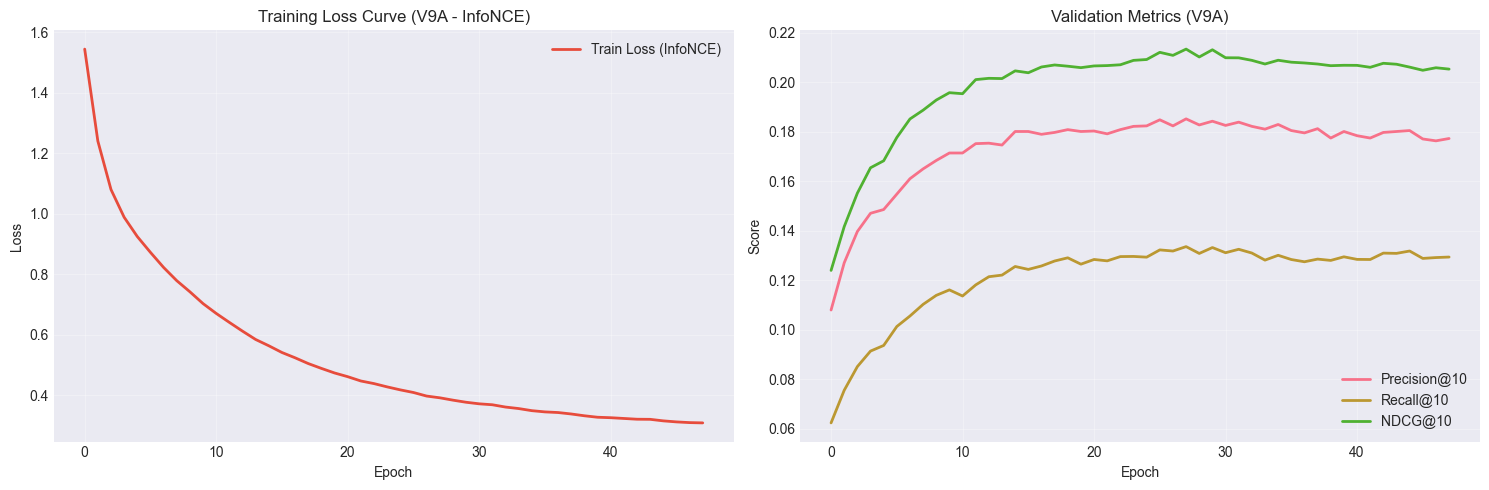

In [12]:
# Training 결과 시각화
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(history['train_loss'], label='Train Loss (InfoNCE)', linewidth=2, color='#e74c3c')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss Curve (V9A - InfoNCE)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history['valid_precision'], label=f'Precision@{CONFIG["top_k"]}', linewidth=2)
axes[1].plot(history['valid_recall'], label=f'Recall@{CONFIG["top_k"]}', linewidth=2)
axes[1].plot(history['valid_ndcg'], label=f'NDCG@{CONFIG["top_k"]}', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Score')
axes[1].set_title('Validation Metrics (V9A)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(CONFIG['result_dir'], 'training_curves_v9a.png'), dpi=300, bbox_inches='tight')
plt.show()

## Test Set 평가

In [13]:
# Test Set 평가
model.load_state_dict(torch.load(os.path.join(CONFIG['model_dir'], 'lightgcn_v9a_best.pth')))

print("=" * 60)
print("Test Set 평가 (V9A - InfoNCE Loss)")
print("=" * 60)

v9a_results = {}

for k in [5, 10, 20]:
    test_metrics = evaluate_model(
        model, 
        train_valid_edge_index,
        test_df, 
        train_valid_user_items,
        n_items, 
        k=k, 
        device=CONFIG['device']
    )
    
    v9a_results[k] = test_metrics
    
    print(f"\nTop-{k} 추천:")
    print(f"  Precision@{k}: {test_metrics[f'precision@{k}']:.4f}")
    print(f"  Recall@{k}:    {test_metrics[f'recall@{k}']:.4f}")
    print(f"  NDCG@{k}:      {test_metrics[f'ndcg@{k}']:.4f}")

print("=" * 60)

Test Set 평가 (V9A - InfoNCE Loss)

Top-5 추천:
  Precision@5: 0.3093
  Recall@5:    0.0947
  NDCG@5:      0.3268

Top-10 추천:
  Precision@10: 0.2669
  Recall@10:    0.1543
  NDCG@10:      0.3044

Top-20 추천:
  Precision@20: 0.2158
  Recall@20:    0.2404
  NDCG@20:      0.3043


## V8a vs V6 비교

In [14]:
print("=" * 60)
print("V9A vs V8a 결과 비교")
print("=" * 60)

# V8a 결과 (baseline)
v6_results = {
    10: {'precision@10': 0.2726, 'recall@10': 0.1541, 'ndcg@10': 0.3093}
}

print("\n핵심 변경사항:")
print(f"  V8a: temp=0.2, neg_ratio=4")
print(f"  v9a: temp={CONFIG['temperature']}, neg_ratio={CONFIG['neg_ratio']}")

print("\nTest Set 성능 (Recall@10):")
print(f"  V8a: {v6_results[10]['recall@10']:.4f} (15.41%)")
print(f"  v9a: {v8a_results[10]['recall@10']:.4f} ({v8a_results[10]['recall@10']*100:.2f}%)")

improvement = (v8a_results[10]['recall@10'] - v6_results[10]['recall@10']) / v6_results[10]['recall@10'] * 100
print(f"  변화: {improvement:+.1f}%")

print("\n전체 지표 비교 (Top-10):")
for metric in ['precision@10', 'recall@10', 'ndcg@10']:
    v6_val = v6_results[10][metric]
    v8a_val = v8a_results[10][metric]
    change = (v8a_val - v6_val) / v6_val * 100
    symbol = '✅' if change > 0 else '❌'
    print(f"  {metric:15s}: v9a={v6_val:.4f}, v9a={v8a_val:.4f} ({change:+.1f}%) {symbol}")

print("\n" + "=" * 60)
print("실험 결과 해석:")
if improvement > 10:
    print("✅ 큰 성공! InfoNCE가 BPR보다 훨씬 효과적")
    print("   → Loss function이 핵심 bottleneck이었음")
    print("   → Temperature 튜닝으로 추가 개선 가능")
elif improvement > 3:
    print("✅ 소폭 개선. InfoNCE가 조금 더 나음")
    print("   → V8b(Softmax)도 시도해보고 최종 결정")
elif improvement > -3:
    print("➖ 비슷한 수준. Loss function 차이 미미")
    print("   → V8b(Softmax) 시도 후 최종 모델 선택")
else:
    print("❌ 성능 하락. BPR이 이 task에 더 적합")
    print("   → V8b(Softmax) 시도 후, 실패 시 V6 (BPR) 선택")
print("=" * 60)

V9A vs V8a 결과 비교

핵심 변경사항:
  V8a: temp=0.2, neg_ratio=4
  v9a: temp=0.1, neg_ratio=4

Test Set 성능 (Recall@10):
  V8a: 0.1541 (15.41%)


NameError: name 'v8a_results' is not defined